# Clustering of the gene embeddings

---

## 0. Environmental setup

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import os
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer
from collections import Counter, OrderedDict
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from scipy.spatial.distance import pdist, squareform
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

from IPython.display import Image

sys.path.append("../../../../")

from src.utils.notebooks.ppi.embedding import *
from src.utils.basic.io import get_genesets_from_gmt_file
from src.models.ae import GCNEncoder
import matplotlib as mpl

seed = 1234

plt.style.use("default")
mpl.rcParams["figure.dpi"] = 600


%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [69]:
def plot_tsne_embs(
    latents,
    ax,
    target,
    target_size=12,
    reg_size=8,
    target_label_size=12,
    reg_label_size=10,
    label_points=None,
    random_state=1234,
):
    embs = TSNE(
        n_components=2,
        random_state=random_state,
        perplexity=np.ceil(np.sqrt(len(latents))),
    ).fit_transform(latents)
    embs = pd.DataFrame(embs, columns=["tsne1", "tsne2"], 
                        index=latents.index)
    ax.scatter(
        np.array(embs.loc[:, "tsne1"]),
        np.array(embs.loc[:, "tsne2"]),
        c="b",
        s=reg_size,
    )
    ax.scatter(
        np.array(embs.loc[target, "tsne1"]),
        np.array(embs.loc[target, "tsne2"]),
        c="r",
        s=target_size,
    )
    if label_points is not None:
        to_label_embs = embs.loc[embs.index.isin(label_points)]
        label_point(
            np.array(to_label_embs.loc[:, "tsne1"]),
            np.array(to_label_embs.loc[:, "tsne2"]),
            np.array(to_label_embs.index).astype("str"),
            ax=ax,
            reg_size=reg_label_size,
            highlight=target,
            highlight_size=target_label_size,
        )
    return ax

<IPython.core.display.Javascript object>

In [26]:
def label_point(
    x, y, val, ax, reg_size=10, highlight_size=10, highlight=None, highlight_other=None
):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    for i in range(len(x)):
        if highlight is not None and val[i] == highlight:
            c = "r"
            weight = "bold"
            size = highlight_size
        elif highlight_other is not None and val[i] in highlight_other:
            c = "b"
            weight = "bold"
        else:
            c = "k"
            weight = "normal"
            size = reg_size
        if x[i] > xmin and x[i] < xmax and y[i] > ymin and y[i] < ymax:
            ax.text(x[i] + 0.02, y[i], val[i], {"size": size, "c": c, "weight": weight})

<IPython.core.display.Javascript object>

In [27]:
def get_colored_clusters(clusters):
    colored_clusters = clusters.copy()
    lut = dict(
        zip(
            list(np.unique(colored_clusters)),
            [
                "tab:blue",
                "tab:red",
                "tab:green",
                "gold",
                "tab:orange",
                "tab:cyan",
                "tab:purple",
                "tab:pink",
                "tab:olive",
                "olivedrab",
                "tab:brown",
            ],
        )
    )
    colored_clusters.loc[:, "color"] = colored_clusters.loc[:, "cluster"].map(lut)
    return colored_clusters

<IPython.core.display.Javascript object>

In [28]:
def read_in_loto_embs(
    root_dir,
    exp_dir,
    gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
):
    oe_targets = sorted(os.listdir(root_dir))

    phy_embs_dict = {}
    reg_embs_dict = {}
    for oe_target in tqdm(oe_targets):
        target_dir = os.path.join(root_dir, oe_target)
        phy_embs = pd.read_hdf(os.path.join(target_dir, "phy_embs.h5"))
        if exclude_ctrl:
            phy_embs = phy_embs.loc[phy_embs.labels != "EMPTY"]
        if avg_phy_embs:
            phy_embs_dict[oe_target] = phy_embs.groupby("labels").mean()
        else:
            phy_embs_dict[oe_target] = phy_embs

        reg_embs = pd.read_csv(
            os.path.join(target_dir, exp_dir, gae_exp, "node_embs.csv"), index_col=0
        )
        if normalize_reg_embs:
            reg_embs = pd.DataFrame(
                normalize(reg_embs), index=reg_embs.index, columns=reg_embs.columns
            )
        reg_embs_dict[oe_target] = reg_embs
    return phy_embs_dict, reg_embs_dict

<IPython.core.display.Javascript object>

In [29]:
def get_linear_comb_weight_dict(reg_embs_dict, phy_embs_dict):
    weight_dict = {}
    oe_targets = set(list(reg_embs_dict.values())[0].index)
    oe_targets = oe_targets.intersection(list(phy_embs_dict.values())[0].index)
    for target in sorted(list(oe_targets)):
        reg_embs = reg_embs_dict[target]
        phy_embs = phy_embs_dict[target]

        shared_targets = set(reg_embs.index).intersection(phy_embs.index)
        phy_embs = phy_embs.loc[shared_targets]

        x = phy_embs.loc[target]
        X = phy_embs.loc[phy_embs.index != target]

        alpha = np.matmul(np.array(x), np.linalg.pinv(np.array(X)))
        weight_dict[target] = pd.DataFrame(alpha, columns=["weight"], index=X.index)
    return weight_dict

<IPython.core.display.Javascript object>

In [110]:
def plot_translation(
    embs,
    fig,
    ax,
    target=None,
    prediction=None,
    target_size=20,
    size=15,
    pred_size=20,
    pred_color="r",
    target_color="coral",
    color="b",
    lw=1,
    alpha=1,
    marker_lw=2,
    p_alpha=0.7,
):

    w = np.abs(embs.loc[:, "weight"])
    scaled_weights = (w - w.min()) / (w.max() - w.min())
    scaled_weights = pd.DataFrame(scaled_weights, index=embs.index, columns=["weight"])

    for gene in list(embs.index):
        x1 = embs.loc[gene, "tsne1"]
        y1 = embs.loc[gene, "tsne2"]
        if prediction is None:
            x2 = embs.loc[target, "tsne1"]
            y2 = embs.loc[target, "tsne2"]
        else:
            x2 = embs.loc[prediction, "tsne1"]
            y2 = embs.loc[prediction, "tsne2"]
        weight = embs.loc[gene, "weight"]
        scaled_weight = scaled_weights.loc[gene, "weight"]
        s = ax.plot(
            [x1, x2],
            [y1, y2],
            linewidth=lw * scaled_weight,
            alpha=alpha * np.abs(weight),
            color=plt.cm.inferno.reversed()(scaled_weight),
            zorder=0,
        )

    exclude = []
    if prediction is not None:
        exclude.append(prediction)
    if target is not None:
        exclude.append(target)

    ax.scatter(
        np.array(embs.loc[~embs.index.isin(exclude), "tsne1"]),
        np.array(embs.loc[~embs.index.isin(exclude), "tsne2"]),
        c=color,
        s=size,
        zorder=1,
        alpha=p_alpha,
    )
    if target is not None:
        ax.scatter(
            np.array(embs.loc[target, "tsne1"]),
            np.array(embs.loc[target, "tsne2"]),
            c=target_color,
            s=target_size,
            zorder=1,
            alpha=1,
            facecolors=target_color,
            edgecolors=target_color,
        )
    if prediction is not None:
        ax.scatter(
            np.array(embs.loc[prediction, "tsne1"]),
            np.array(embs.loc[prediction, "tsne2"]),
            # c=pred_color,
            s=pred_size,
            zorder=1,
            facecolors="none",
            edgecolors=pred_color,
            linewidth=marker_lw,
            alpha=1,
        )
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cmap = plt.cm.inferno.reversed()
    m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    fig.colorbar(m)

    return fig, ax

<IPython.core.display.Javascript object>

---

## 1. Read in data

In [30]:
phy_oe_emb_dir = (
    "../../../../data/experiments/rohban/images/embeddings/leave_one_target_out/embeddings"
)
oe_targets = os.listdir(phy_oe_emb_dir)
oe_targets = sorted(oe_targets)
physical_cluster_dict = {}
for target in oe_targets:
    physical_cluster_dict[target] = pd.read_csv(
        os.path.join(phy_oe_emb_dir, target, "train_phy_mean_clusters.csv"), index_col=0
    )

<IPython.core.display.Javascript object>

In [31]:
physical_full_cluster_dict = {}
for target in oe_targets:
    physical_full_cluster_dict[target] = pd.read_csv(
        os.path.join(phy_oe_emb_dir, target, "phy_mean_full_clusters.csv"), index_col=0
    )

<IPython.core.display.Javascript object>

In [32]:
hallmark_geneset_dict = get_genesets_from_gmt_file(
    "../../../../data/resources/genesets/h.all.v7.4.symbols.gmt"
)

l1000_genes = set(
    list(
        pd.read_csv(
            "../../../../data/resources/genesets/l1000.txt", index_col=0, header=None
        ).index
    )
)


<IPython.core.display.Javascript object>

In [33]:
gene_embeddings = pd.read_csv(
    "../../../../data/experiments/rohban/interactome/embeddings/all_reg_embs", index_col=0
)

<IPython.core.display.Javascript object>

---

## 2. Clustering of the gene embeddings

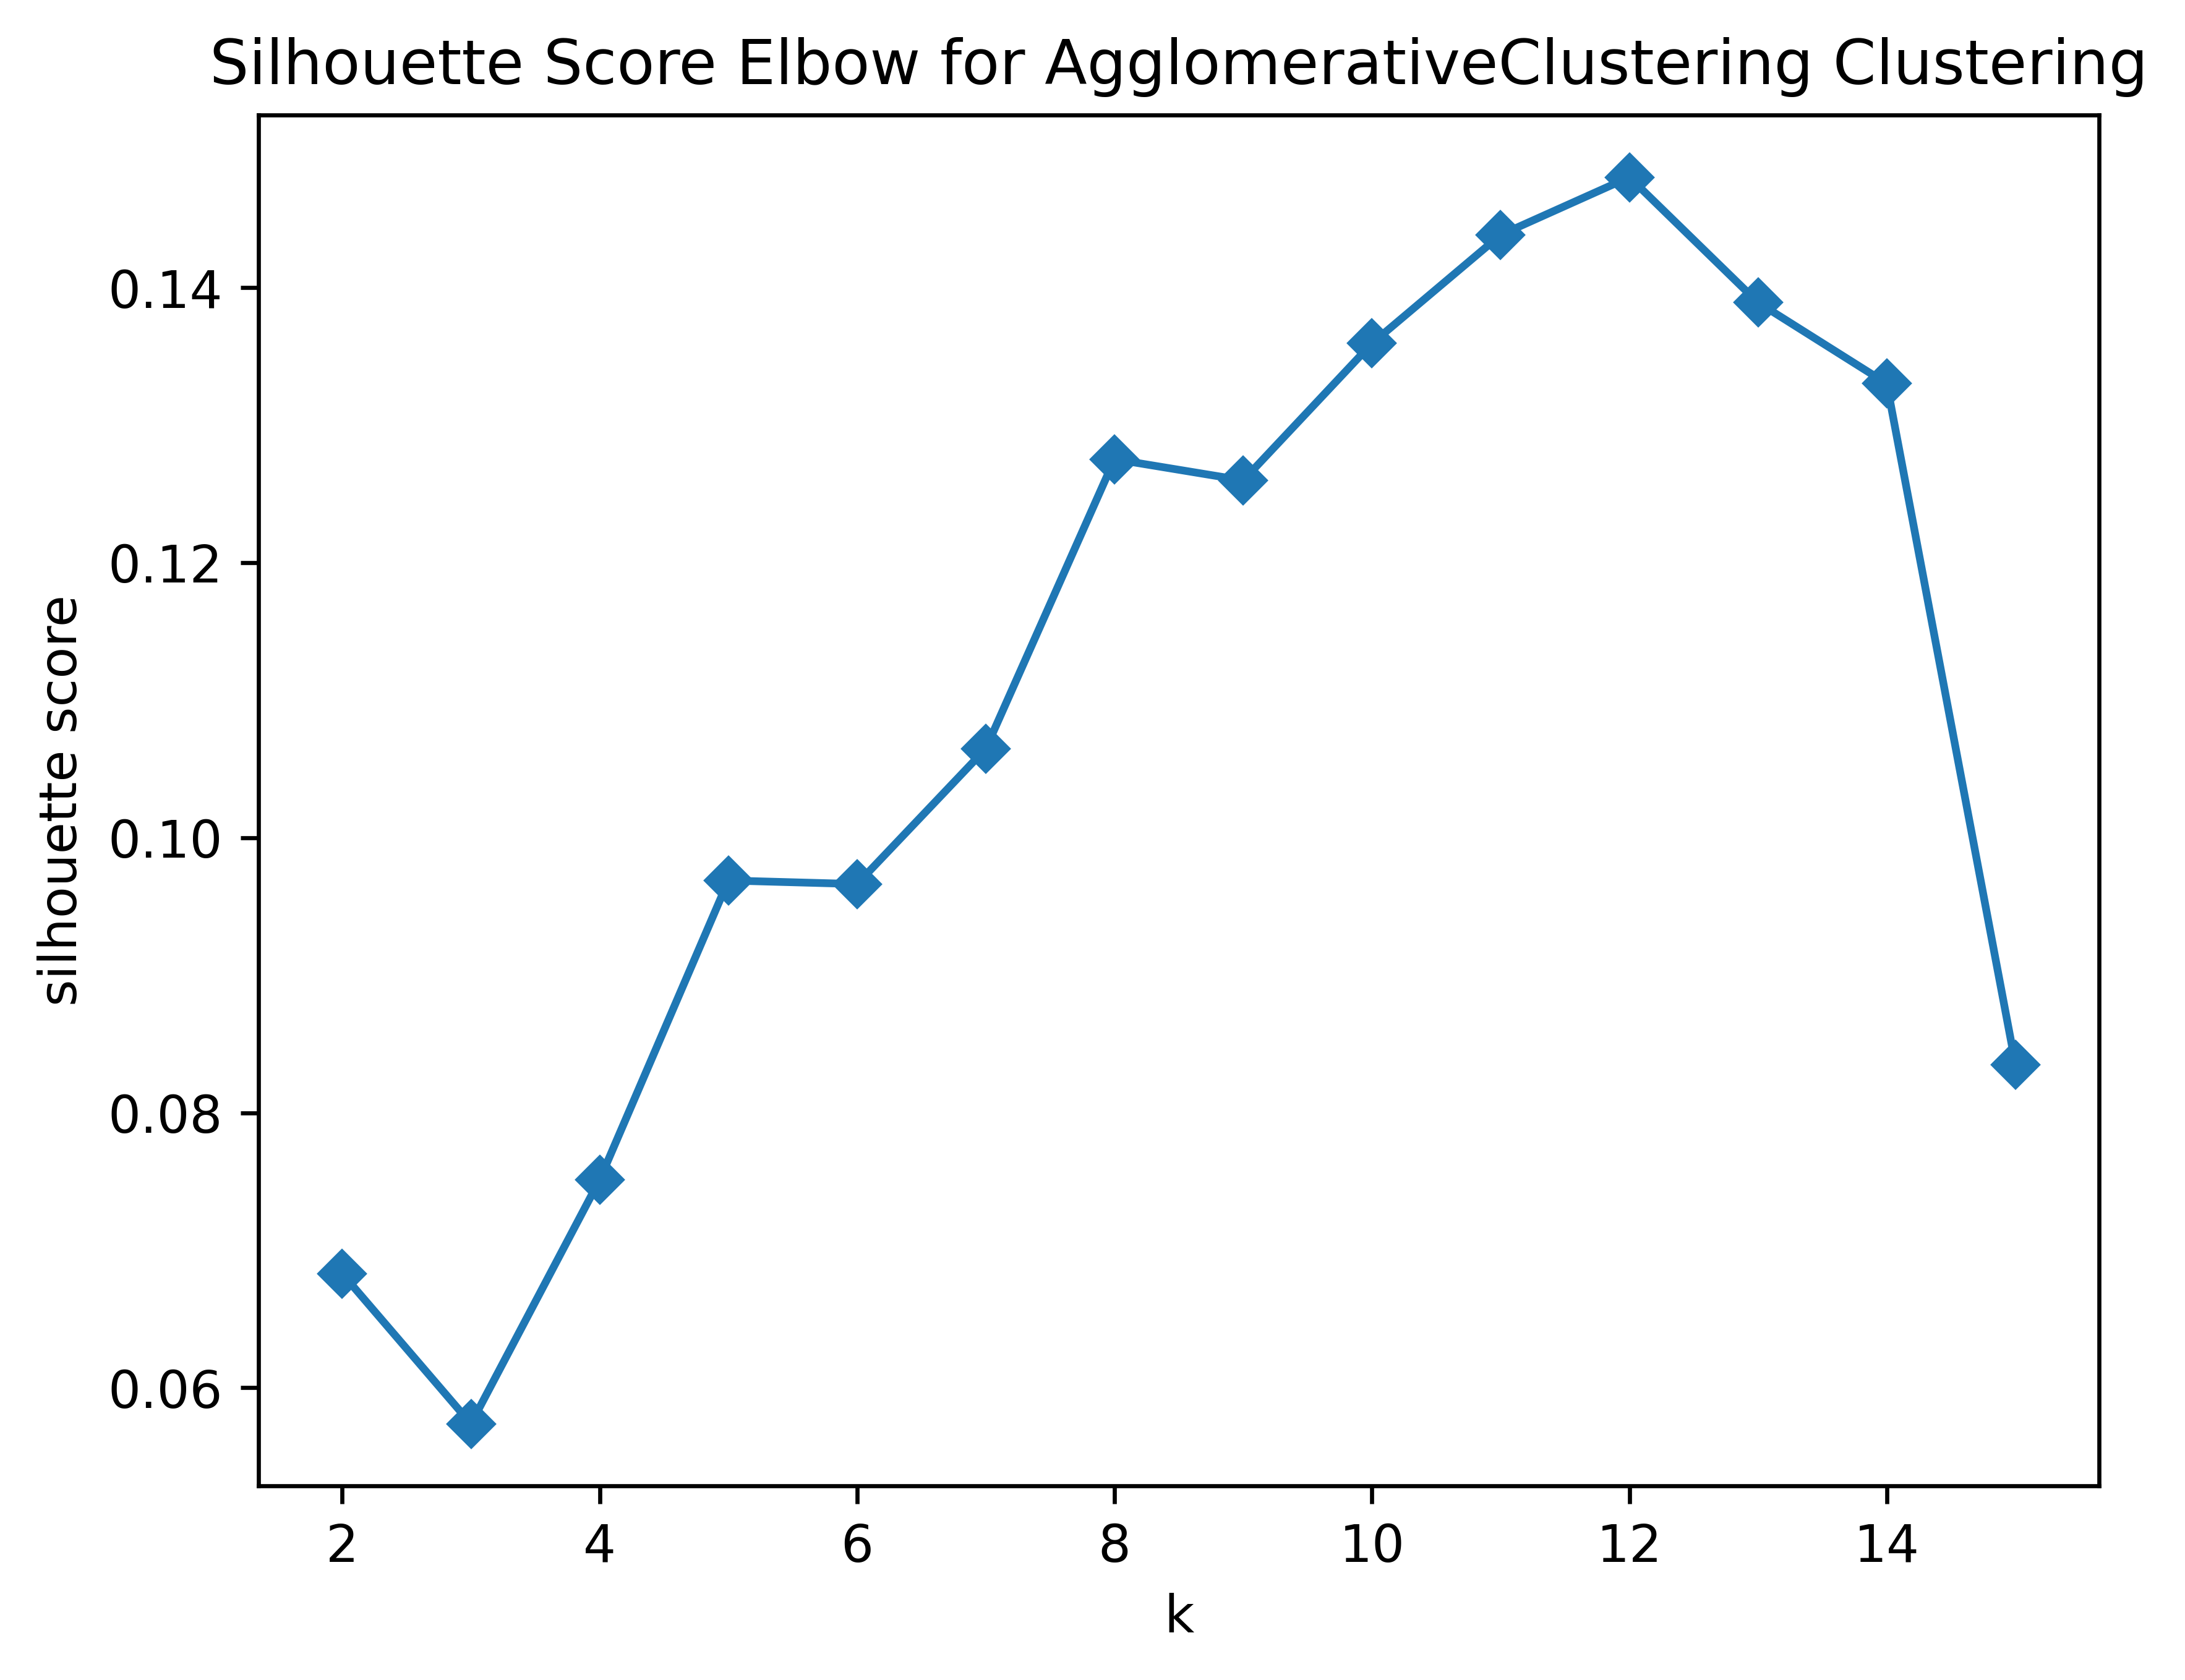

<IPython.core.display.Javascript object>

In [10]:
model = AgglomerativeClustering(affinity="cosine", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(gene_embeddings)
ax = visualizer.show()

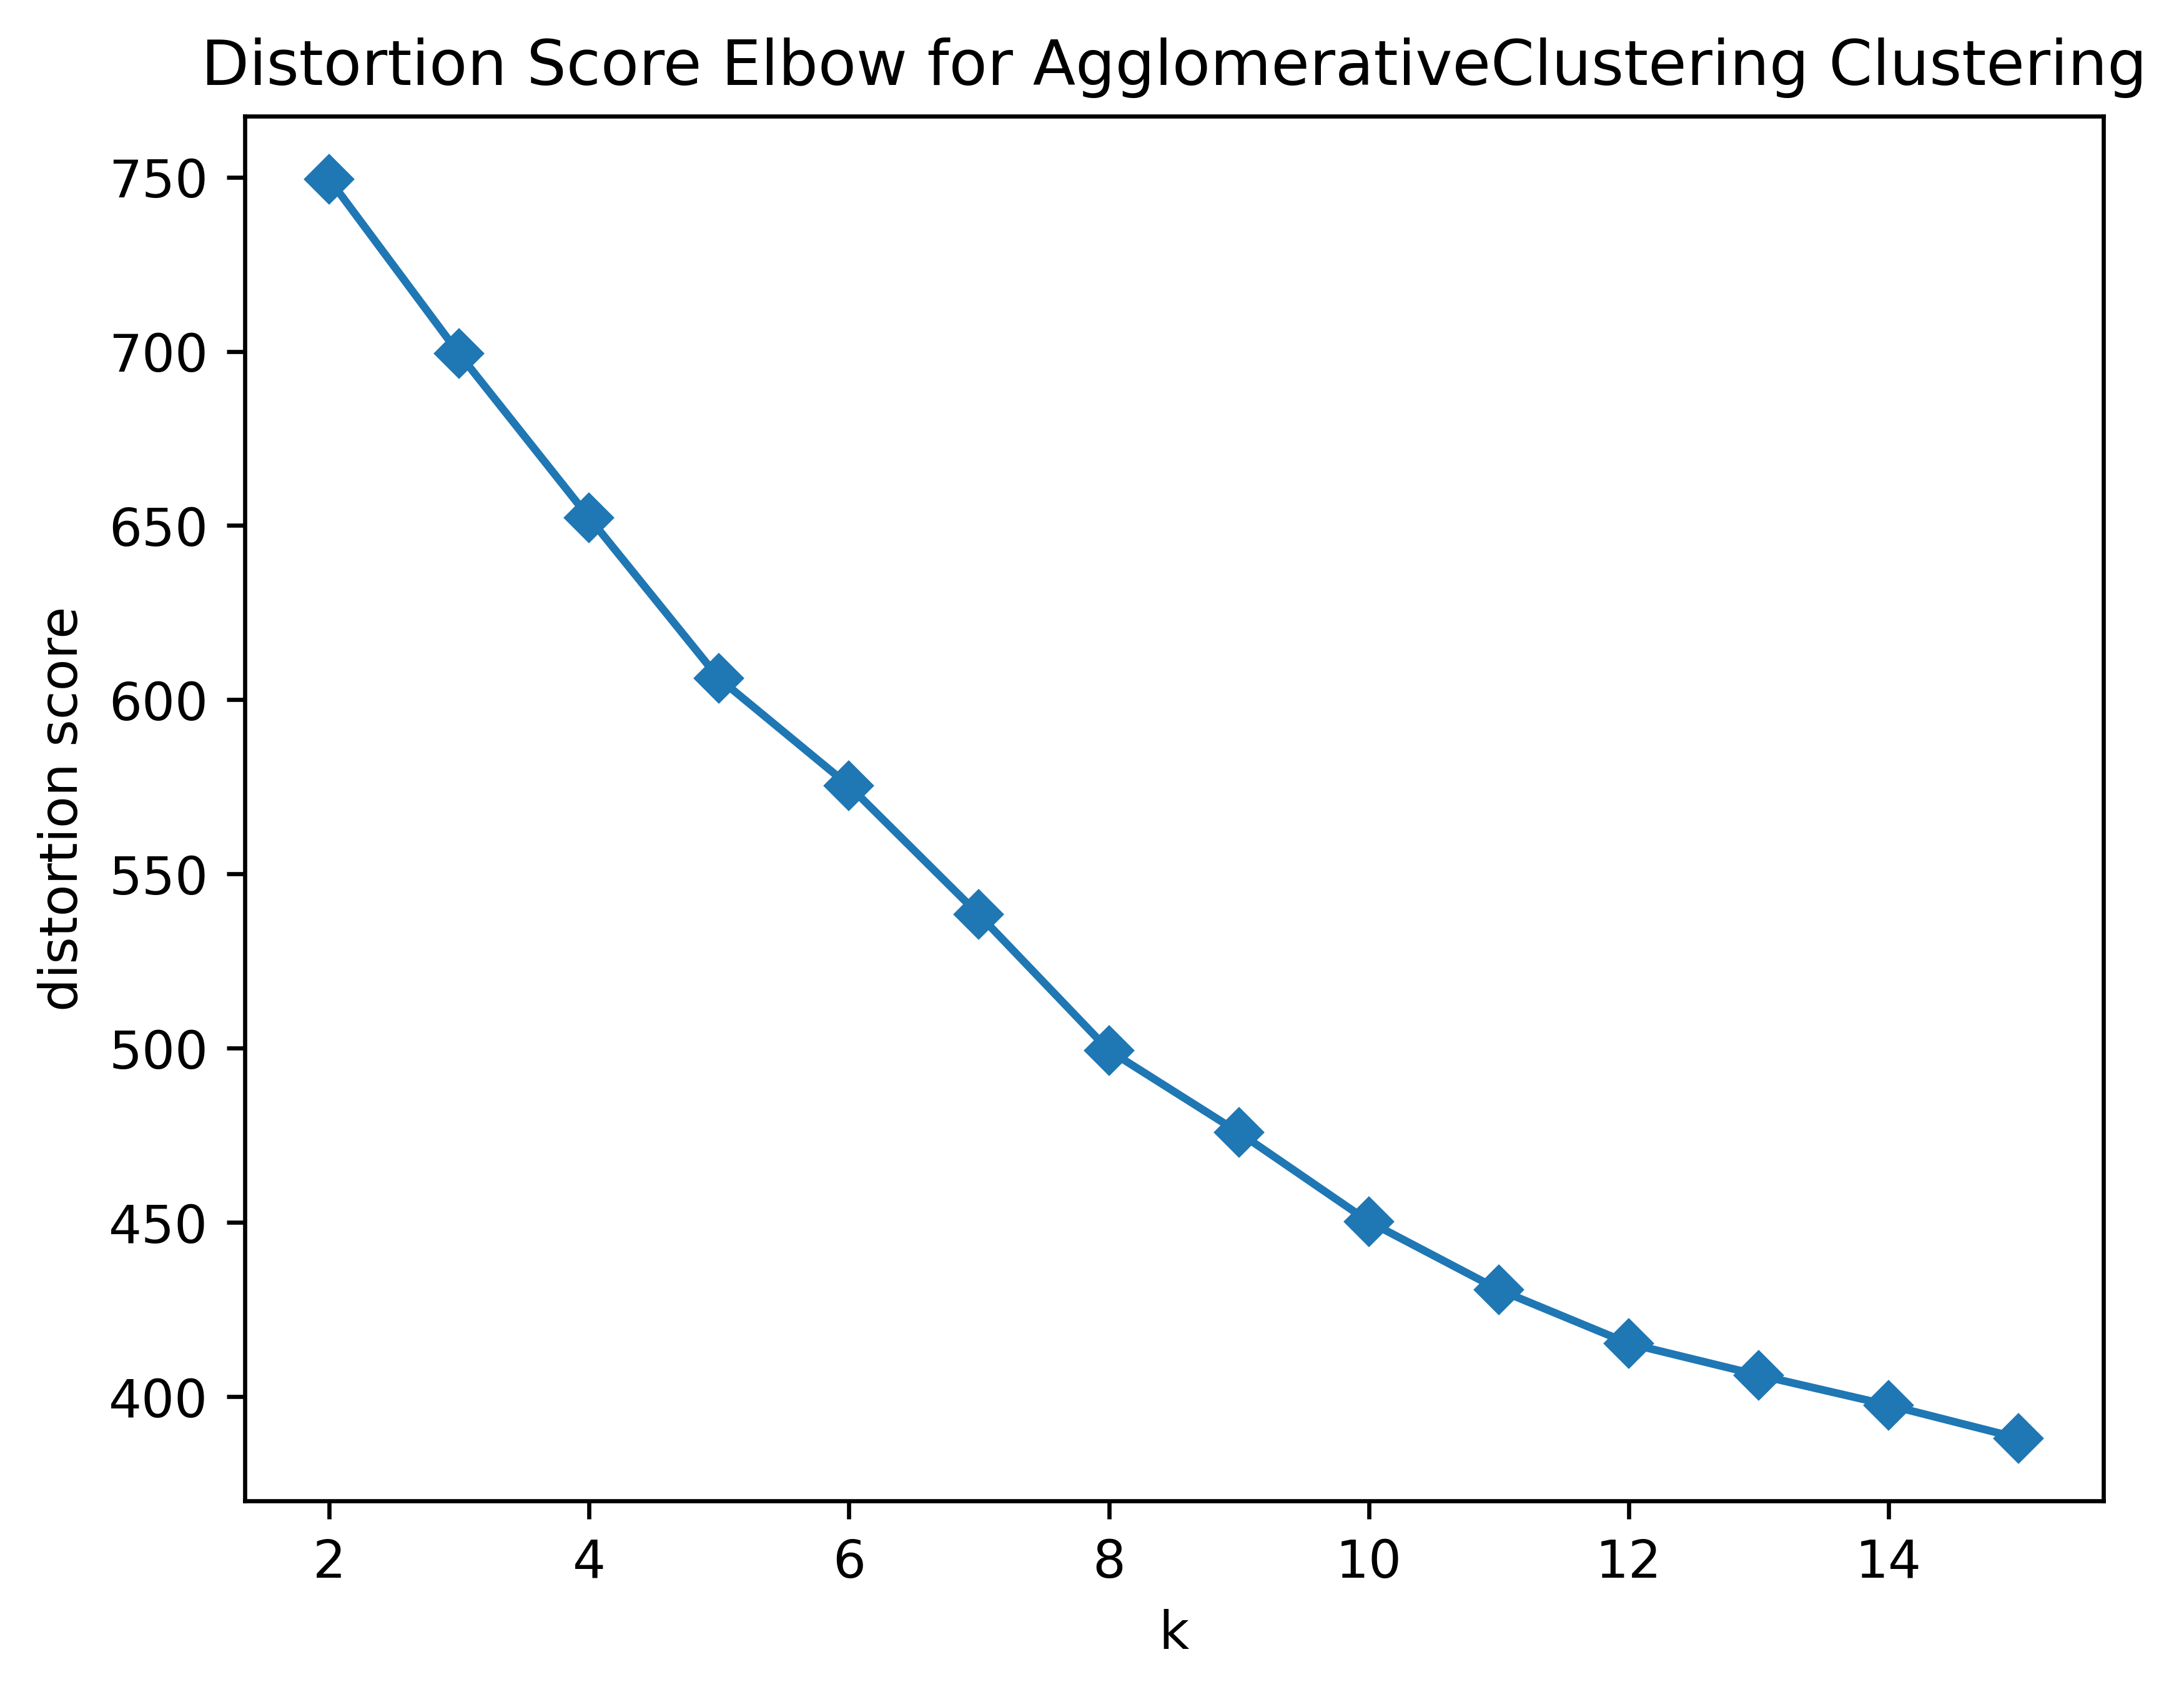

<IPython.core.display.Javascript object>

In [11]:
visualizer = KElbowVisualizer(
    model, k=15, metric="distortion", timings=False, locate_elbow=False
)

visualizer.fit(gene_embeddings)
ax = visualizer.show()

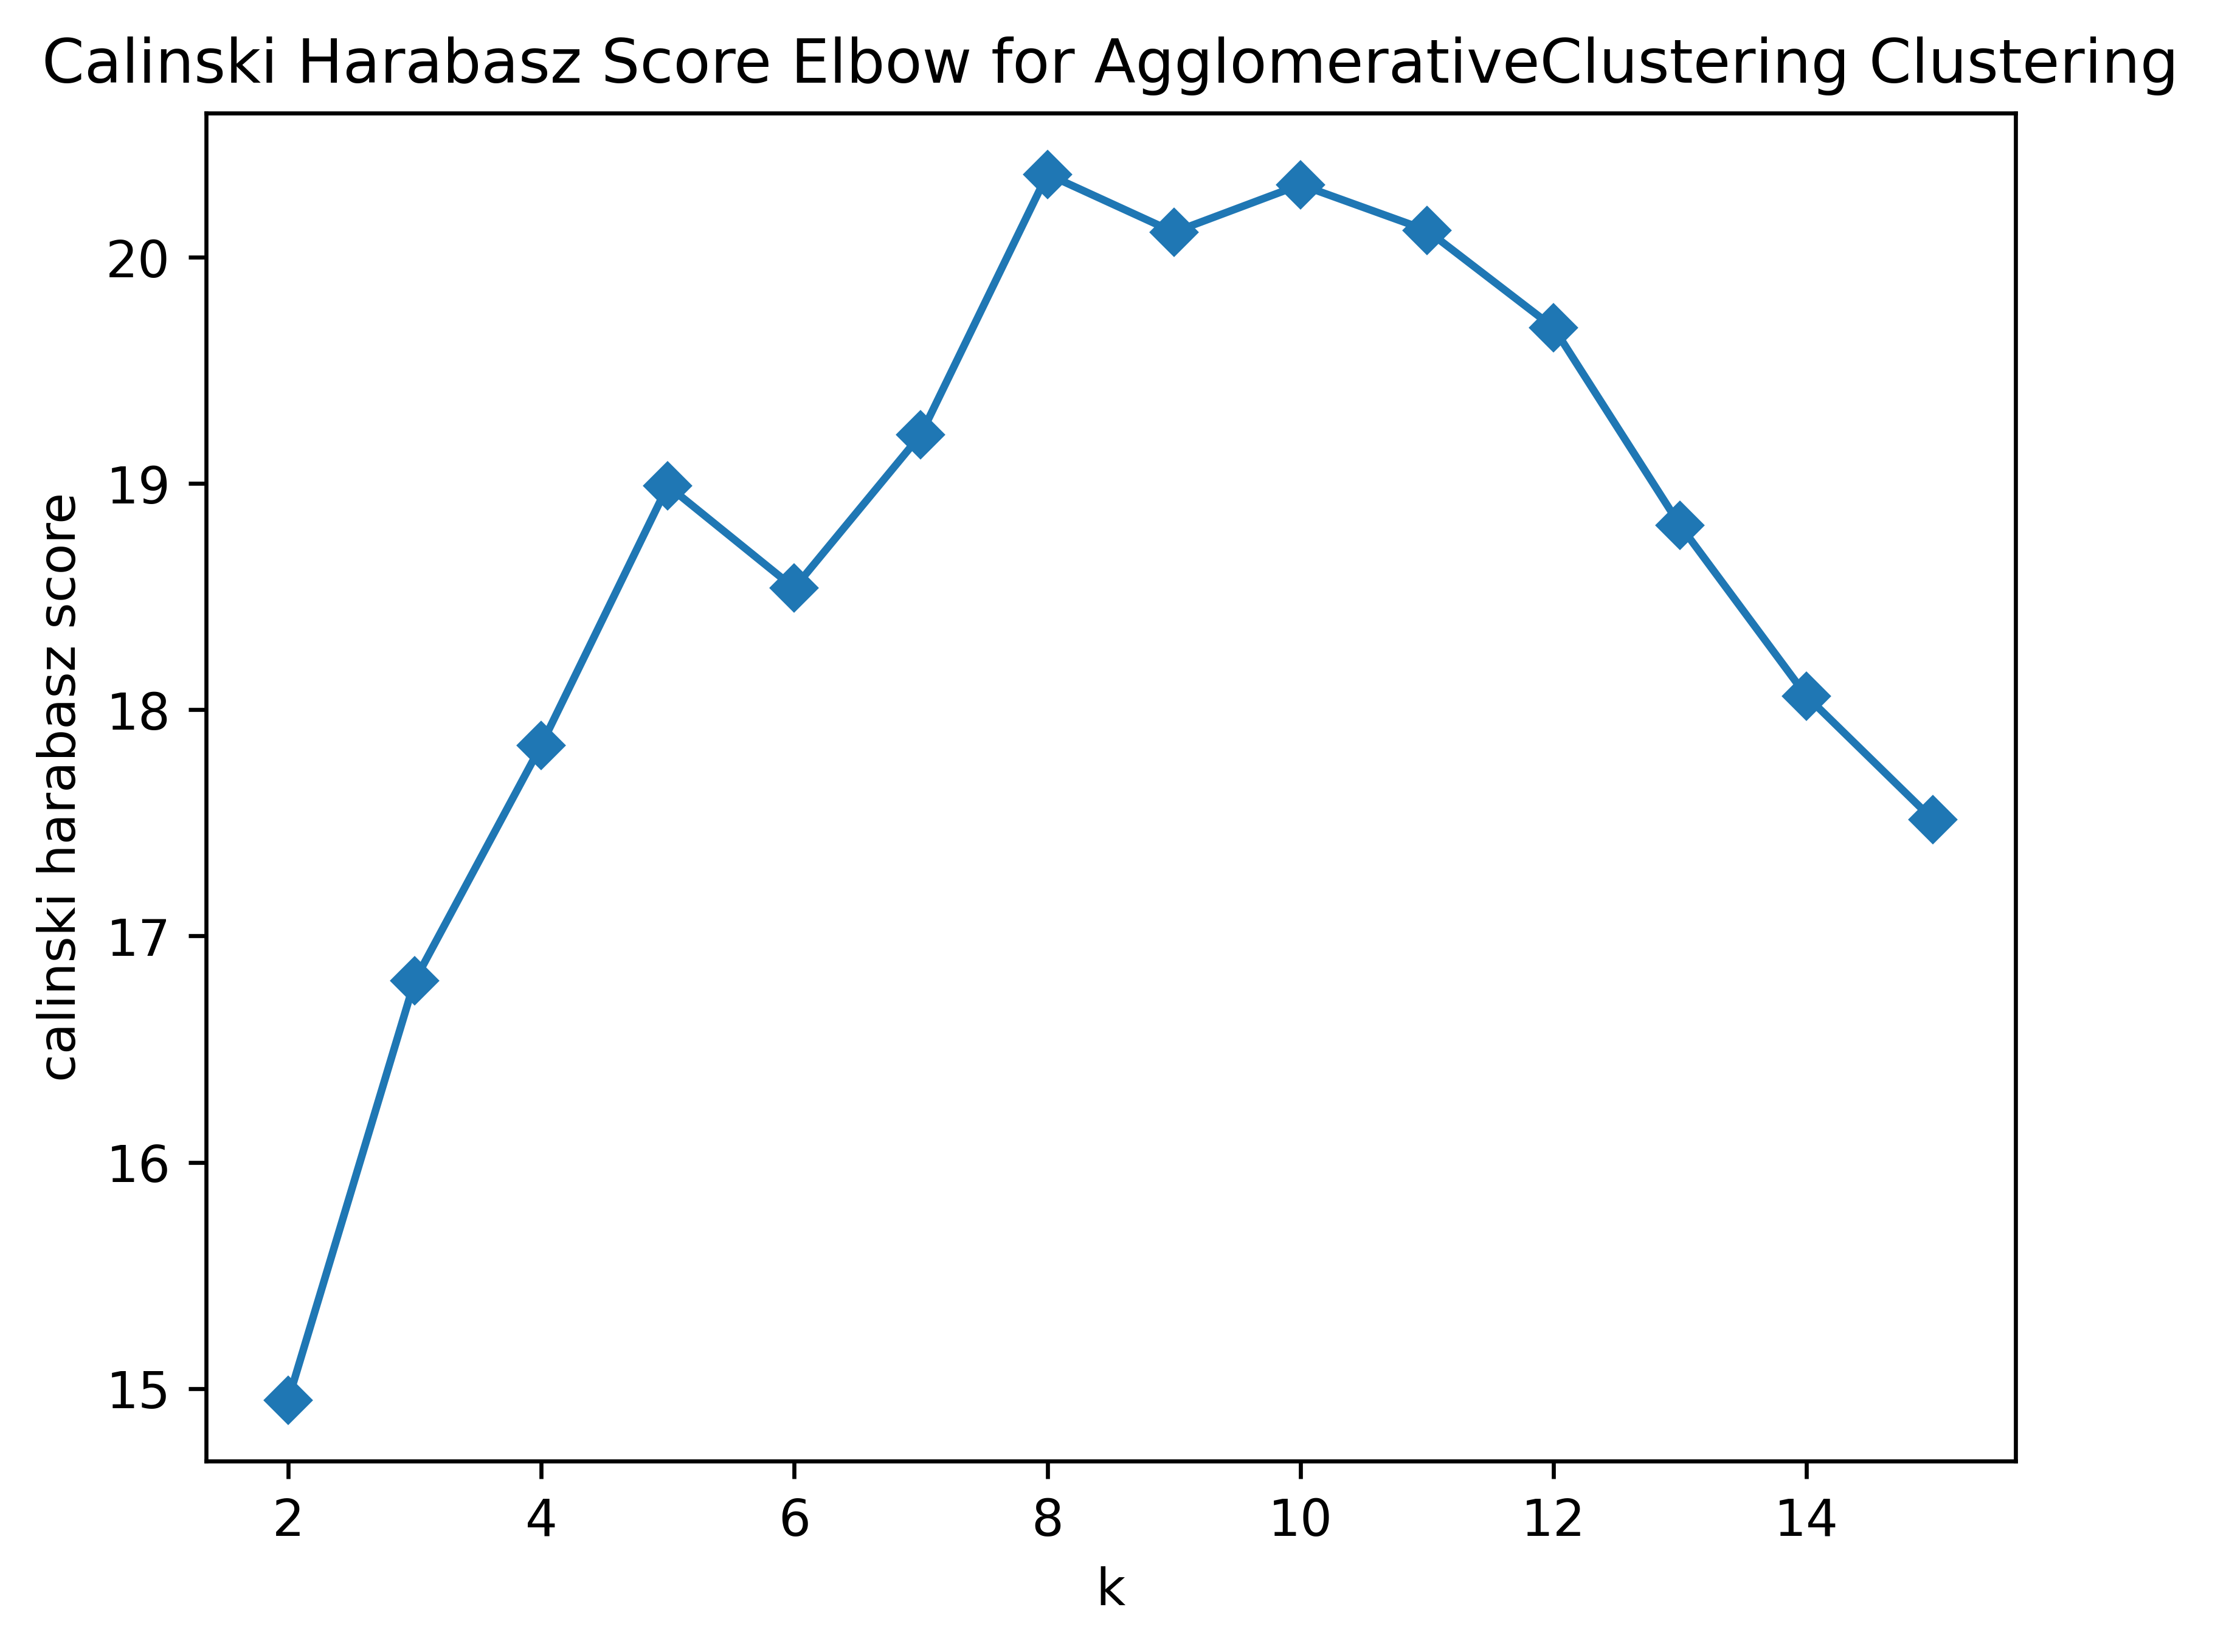

<IPython.core.display.Javascript object>

In [12]:
visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(gene_embeddings)
ax = visualizer.show()

In [13]:
model = model = AgglomerativeClustering(
    affinity="cosine", linkage="complete", n_clusters=8
)
cluster_labels = model.fit_predict(gene_embeddings)
cluster_dict = {}
for cluster_label in np.unique(cluster_labels):
    cluster_dict[cluster_label] = list(
        np.array(list(gene_embeddings.index))[cluster_labels == cluster_label]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, sorted(v)))
    print("")

Cluster 0: ['ACAN', 'AKT1S1', 'APPBP2', 'ARMCX2', 'ATXN7', 'AXL', 'BMP4', 'COL1A1', 'COL4A1', 'COL4A2', 'COL5A1', 'DHRS2', 'DSP', 'EFEMP1', 'FBLN1', 'FBN1', 'FBN2', 'FGF1', 'FGFR2', 'FGFR3', 'FN1', 'FSTL1', 'HAPLN1', 'HSPG2', 'IGF2', 'IGFBP5', 'INHBA', 'KLK6', 'KRT80', 'KRT81', 'LAMA1', 'LRP1', 'LTBP2', 'MAGEA6', 'MDK', 'MFAP2', 'MMP2', 'MYH9', 'MYL9', 'NEFL', 'PCOLCE', 'PDGFRB', 'PIK3R2', 'PLAT', 'PLCG1', 'S100A14', 'SERPINE1', 'SPARC', 'SRC', 'TGFB1', 'TGM2', 'THBS1', 'THY1', 'TIMP1', 'TNC', 'UCHL5', 'VCAN']

Cluster 1: ['ATF4', 'BAX', 'C1QL1', 'CLU', 'CREB1', 'GABRB3', 'GIT1', 'GLI2', 'GNAQ', 'GSK3B', 'IRAK4', 'MAP2K3', 'MAPK7', 'MBP', 'MDC1', 'NOTCH3', 'PCLO', 'PLCB2', 'PRKACA', 'PRKCA', 'PRSS23', 'RELB', 'TNNC1', 'TNNT2', 'TRIB3', 'UBE2C']

Cluster 2: ['BRAF', 'CDC42', 'CDC42EP1', 'CDK14', 'CNN1', 'CRMP1', 'EPB41L3', 'FKBP4', 'HK2', 'HRAS', 'HSP90AB1', 'HSPB1', 'KPNA2', 'KRT15', 'KRT18', 'KRT8', 'LGALS1', 'MAGEA1', 'MAGEA12', 'MAGEA4', 'MAGED1', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MYL2

<IPython.core.display.Javascript object>

In [17]:
cluster_solution = pd.DataFrame(np.array(gene_embeddings.index), columns=["gene"])
cluster_solution.loc[:, "cluster"] = cluster_labels
#cluster_solution.to_csv("../../../data/other/all_gene_embeddings_clusters.csv")

<IPython.core.display.Javascript object>

---

## 3. Visualization of the gene embeddings

In [11]:
cluster_solution = pd.read_csv(
    "../../../../data/experiments/rohban/interactome/cluster_infos/all_gene_embeddings_clusters.csv", index_col=0
)

<IPython.core.display.Javascript object>

In [257]:
cluster_solution.index = np.array(cluster_solution.loc[:, "gene"])

normalized_embeddings = pd.DataFrame(
    normalize(gene_embeddings),
    index=gene_embeddings.index,
    columns=gene_embeddings.columns,
)
tsne = TSNE(
    random_state=1234,
    perplexity=np.ceil(np.sqrt(len(normalized_embeddings))),
    init="pca",
    learning_rate=200,
    n_iter=1000,
)
embs = tsne.fit_transform(normalized_embeddings)
embs = pd.DataFrame(
    embs, index=normalized_embeddings.index, columns=["tsne_0", "tsne_1"]
)
embs.loc[:, "cluster"] = np.array(cluster_solution.loc[embs.index, "cluster"]).astype(
    str
)

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

Text(0, 0.5, '')

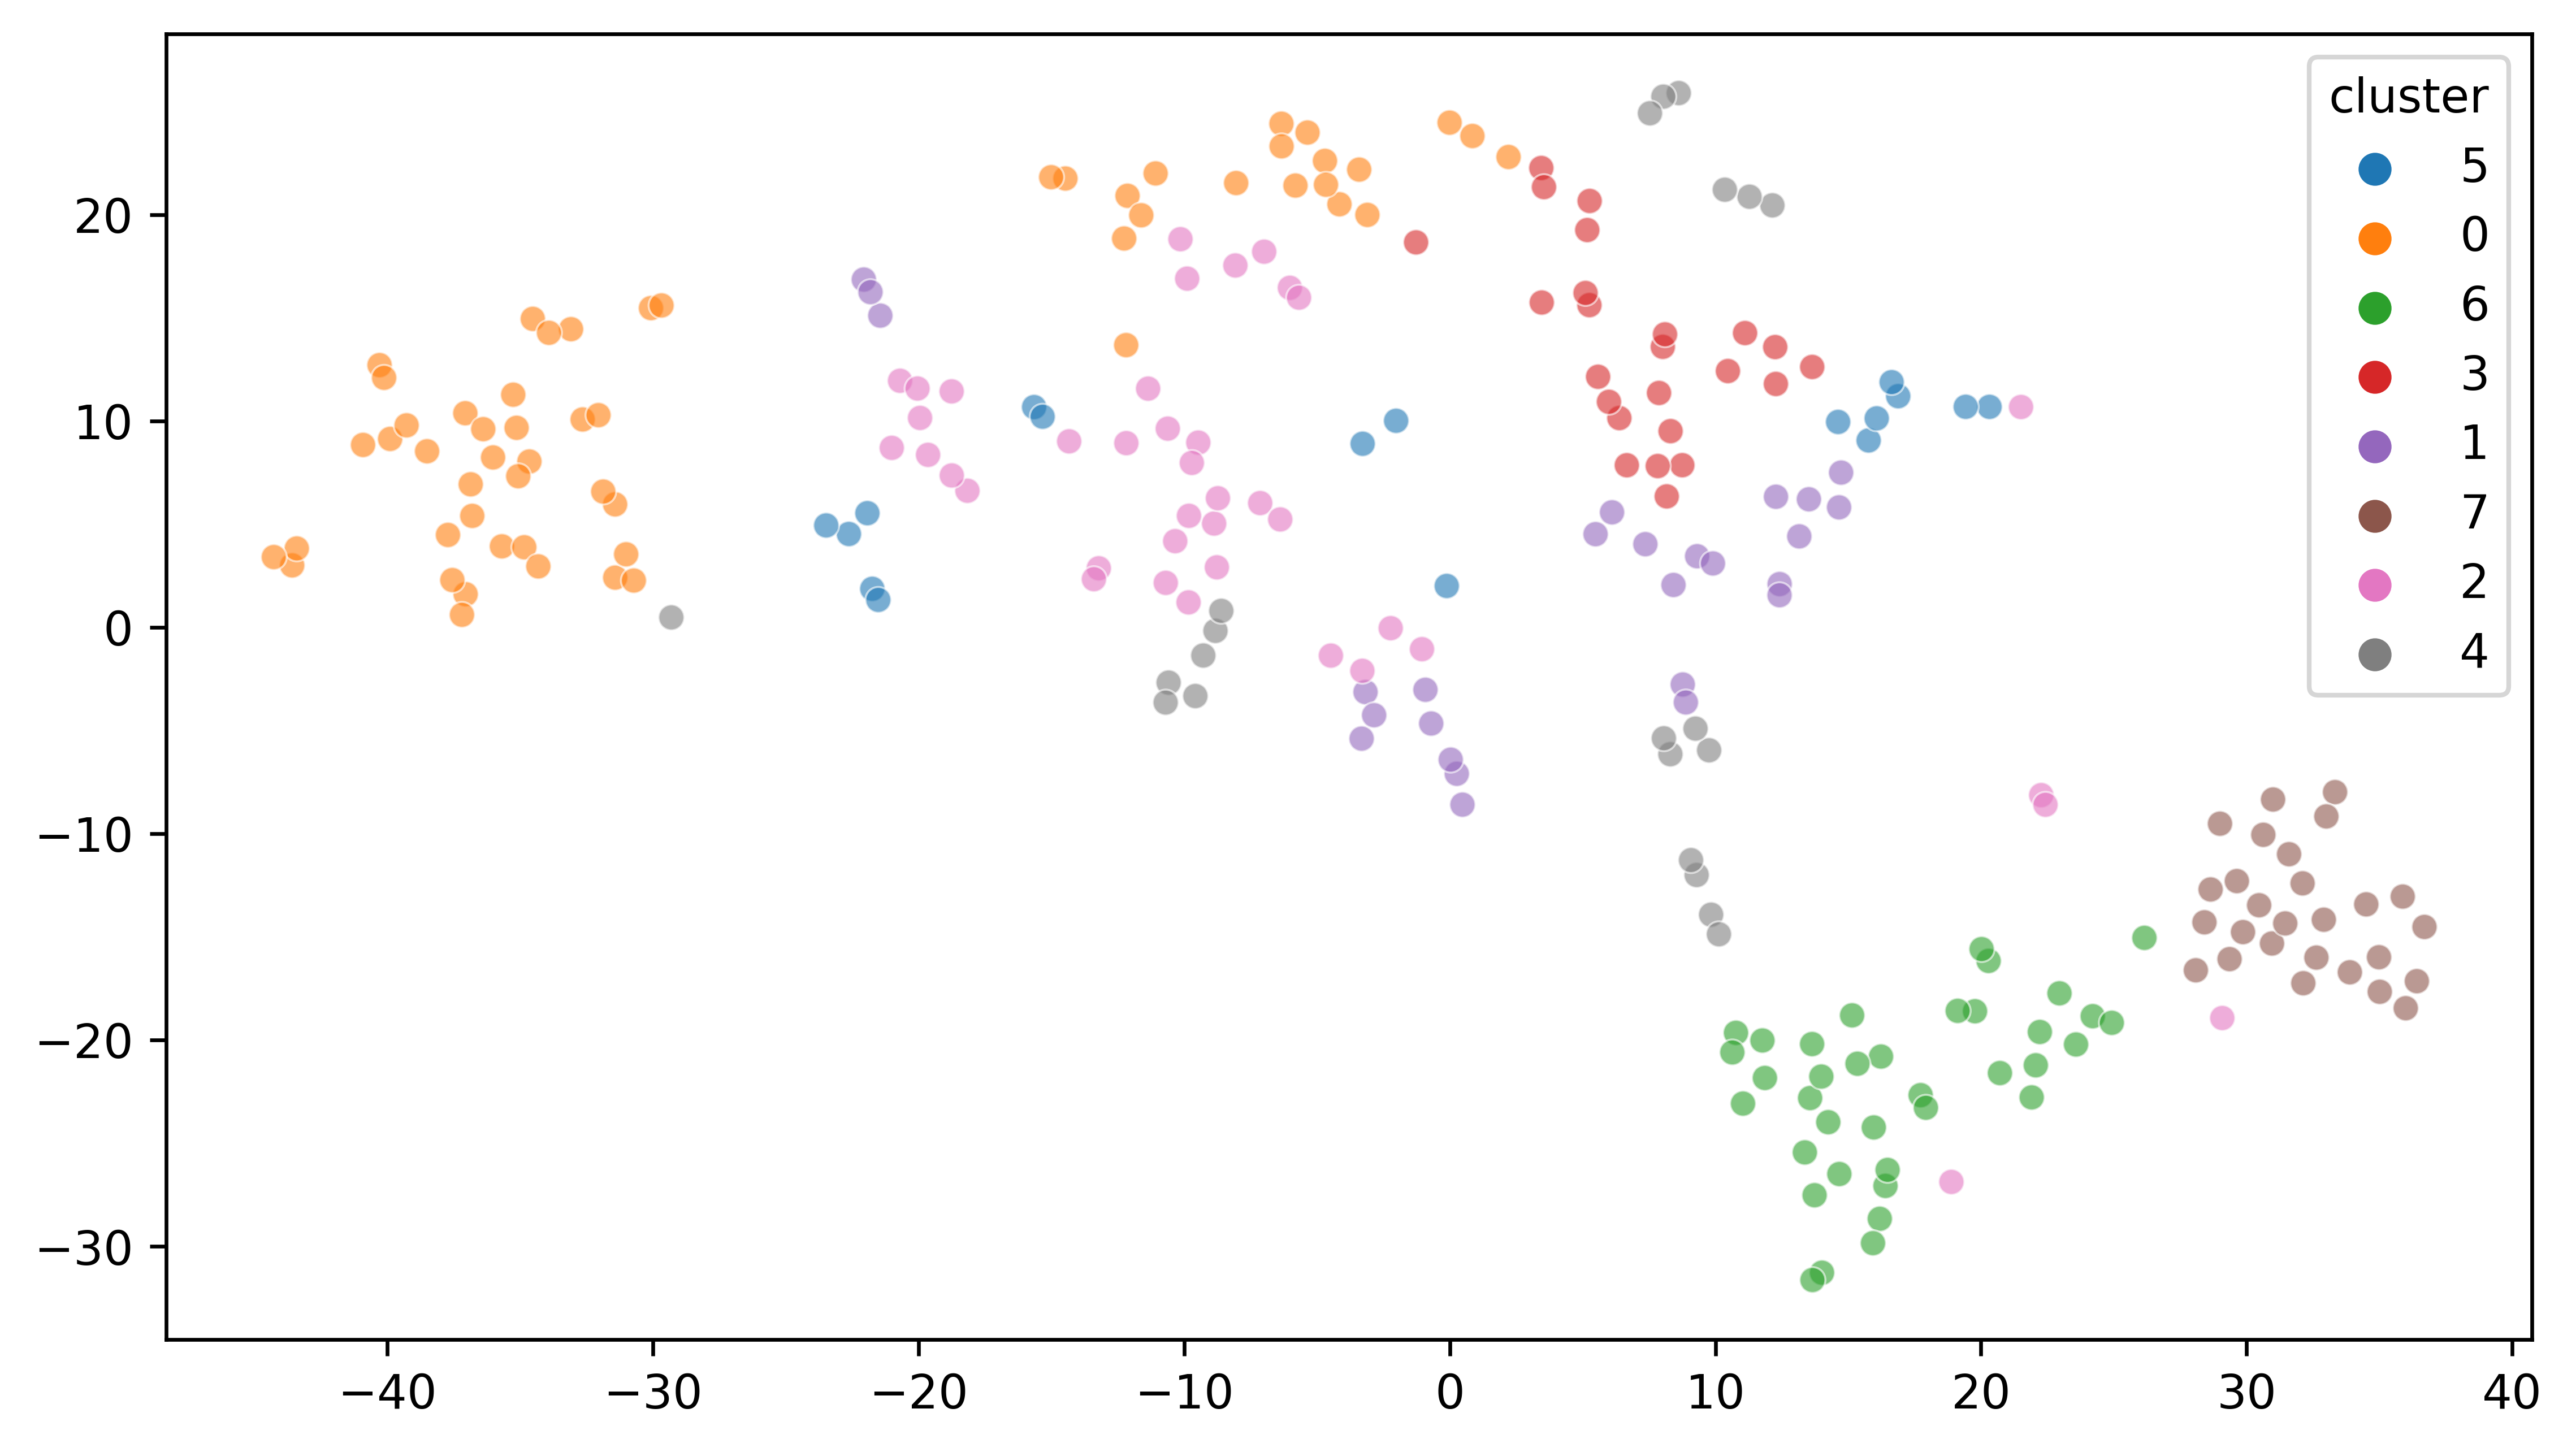

<IPython.core.display.Javascript object>

In [258]:
fig, ax = plt.subplots(figsize=[9, 5])
ax = sns.scatterplot(
    data=embs,
    x="tsne_0",
    y="tsne_1",
    hue="cluster",
    ax=ax,
    palette="tab10",
    legend=True,
    s=30,
    alpha=0.6,
)
ax.set_xlabel("")
ax.set_ylabel("")

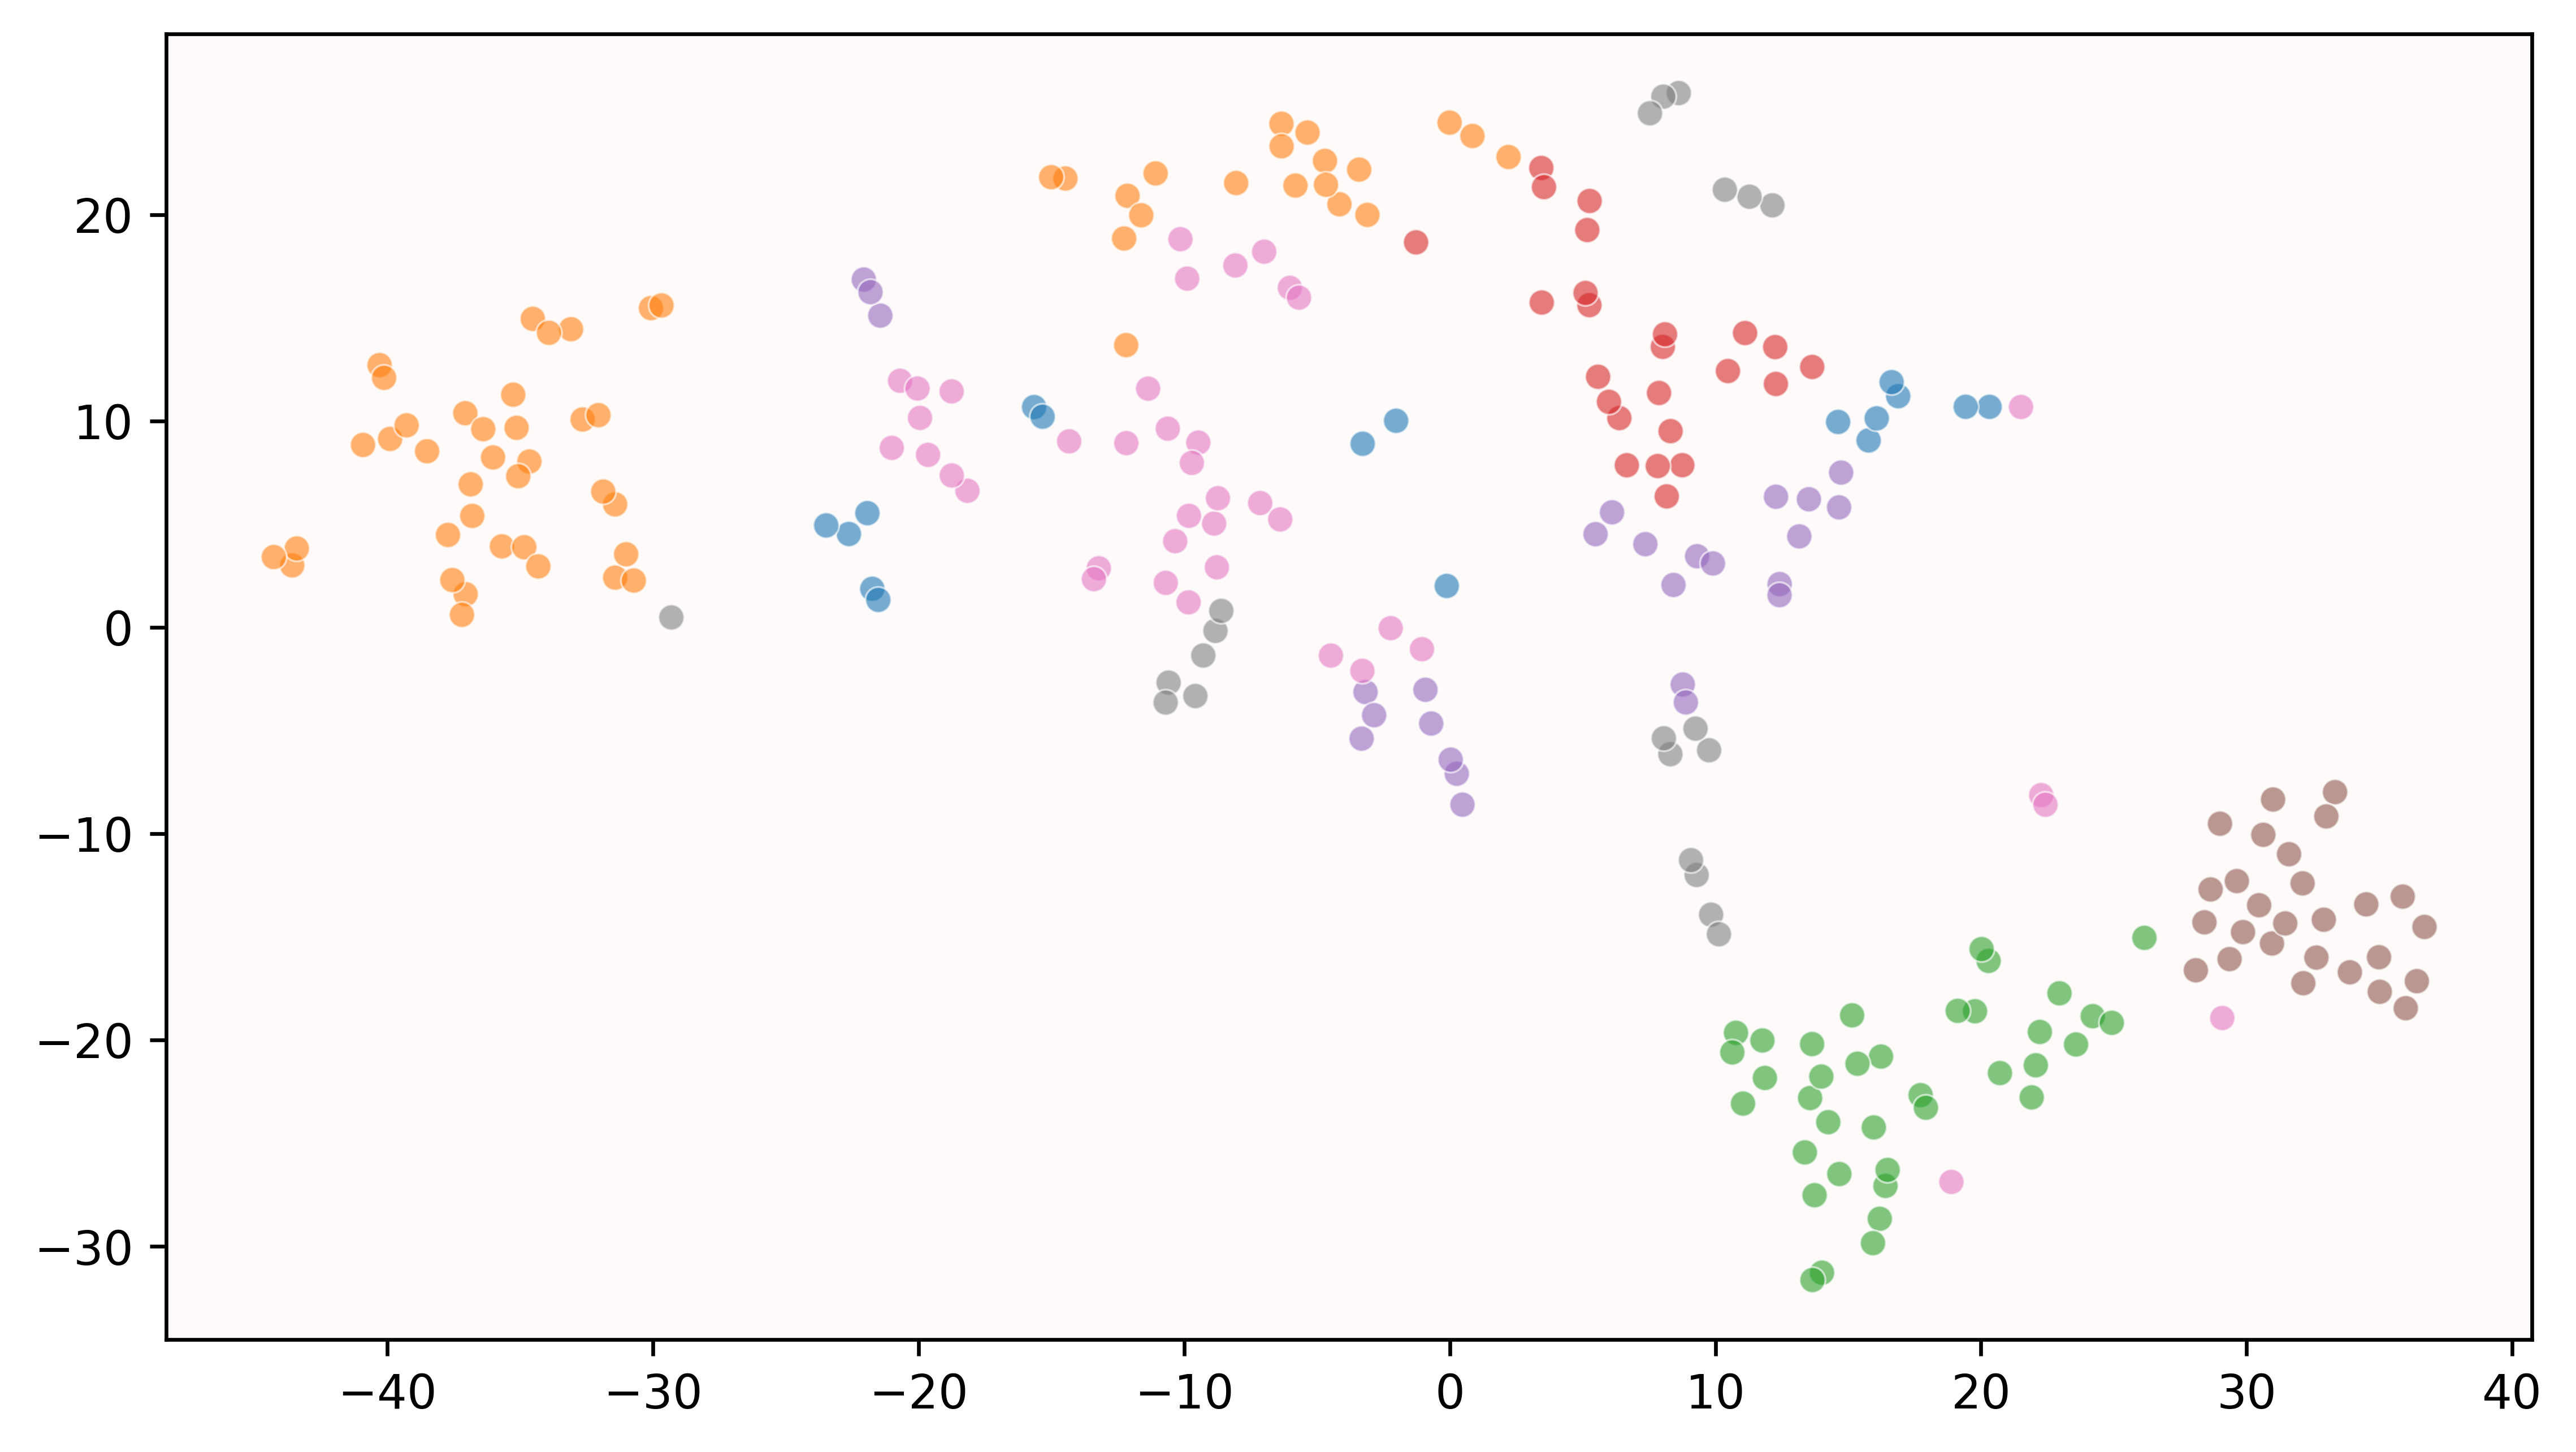

<IPython.core.display.Javascript object>

In [261]:
fig, ax = plt.subplots(figsize=[9, 5])
ax = sns.scatterplot(
    data=embs,
    x="tsne_0",
    y="tsne_1",
    hue="cluster",
    ax=ax,
    palette="tab10",
    legend=False,
    s=30,
    alpha=0.6,
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_facecolor("snow")

In [128]:
fig, ax = plt.subplots(figsize=[28, 10])
for i in range(len(embs)):
    x = embs.iloc[i, 0]
    y = embs.iloc[i, 1]
    label = list(embs.index)[i]
    ax.text(x + 0.01, y + 0.01, label, {"size": 8, "c": c})
    c = "grey"
    alpha = 0.3
    ax.scatter(x, y, c=c, alpha=alpha, s=10)

plt.show()

<IPython.core.display.Javascript object>

## 4. Visualization of the alignment of the gene perturbation and gene embeddings

In [34]:
root_dir = (
    "../../../../data/experiments/rohban/images/embeddings/leave_one_target_out/embeddings"
)
exp_dir = "spearman_sol"
gae_exp = "gae_exp_a1_b0_g1_split_graph_physical"
phy_embs_dict_101_s_phy, reg_embs_dict_101_s_phy = read_in_loto_embs(
    root_dir=root_dir,
    exp_dir=exp_dir,
    gae_exp=gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
)

100%|██████████| 42/42 [01:24<00:00,  2.01s/it]


<IPython.core.display.Javascript object>

In [35]:
weight_dict = get_linear_comb_weight_dict(
    phy_embs_dict=phy_embs_dict_101_s_phy,
    reg_embs_dict=reg_embs_dict_101_s_phy,
)

<IPython.core.display.Javascript object>

### RAF1

In [63]:
target = "RAF1"

<IPython.core.display.Javascript object>

In [64]:
phy_embs_raf = phy_embs_dict_101_s_phy[target]
reg_embs_raf = reg_embs_dict_101_s_phy[target]
weights = weight_dict[target]

<IPython.core.display.Javascript object>

In [65]:
prediction_raf = np.matmul(
    np.array(weights).flatten(), np.array(reg_embs_raf.loc[weights.index])
)
reg_embs_w_pred_raf = reg_embs_raf.copy()
reg_embs_w_pred_raf.loc["PREDICTION"] = prediction_raf

<IPython.core.display.Javascript object>

In [66]:
tsne_phy = TSNE(
    random_state=1234, n_components=2, perplexity=np.ceil(np.sqrt(len(phy_embs_raf)))
)

phy_tsne_raf = pd.DataFrame(
    tsne_phy.fit_transform(phy_embs_raf),
    columns=["tsne1", "tsne2"],
    index=phy_embs_raf.index,
)
phy_tsne_raf["weight"] = 0
phy_tsne_raf.loc[weights.index, "weight"] = weights.loc[:, "weight"]

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>

In [67]:
tsne_reg = TSNE(
    random_state=1234,
    n_components=2,
    perplexity=np.ceil(np.sqrt(len(reg_embs_w_pred_raf))),
)

reg_tsne_raf = pd.DataFrame(
    tsne_reg.fit_transform(reg_embs_w_pred_raf),
    columns=["tsne1", "tsne2"],
    index=reg_embs_w_pred_raf.index,
)
reg_tsne_raf["weight"] = 0
reg_tsne_raf.loc[weights.index, "weight"] = weights.loc[:, "weight"]

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>

In [104]:
fig, ax = plt.subplots(figsize=[24, 12])
ax = plot_tsne_embs(
    phy_embs_raf,
    label_points=list(phy_embs_raf.index),
    ax=ax,
    target=target,
)

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>

In [56]:
fig, ax = plt.subplots(figsize=[24, 12])
ax = plot_tsne_embs(
    reg_embs_w_pred_raf,
    label_points=list(reg_embs_w_pred_raf.index),
    ax=ax,
    target=target,
)

<IPython.core.display.Javascript object>

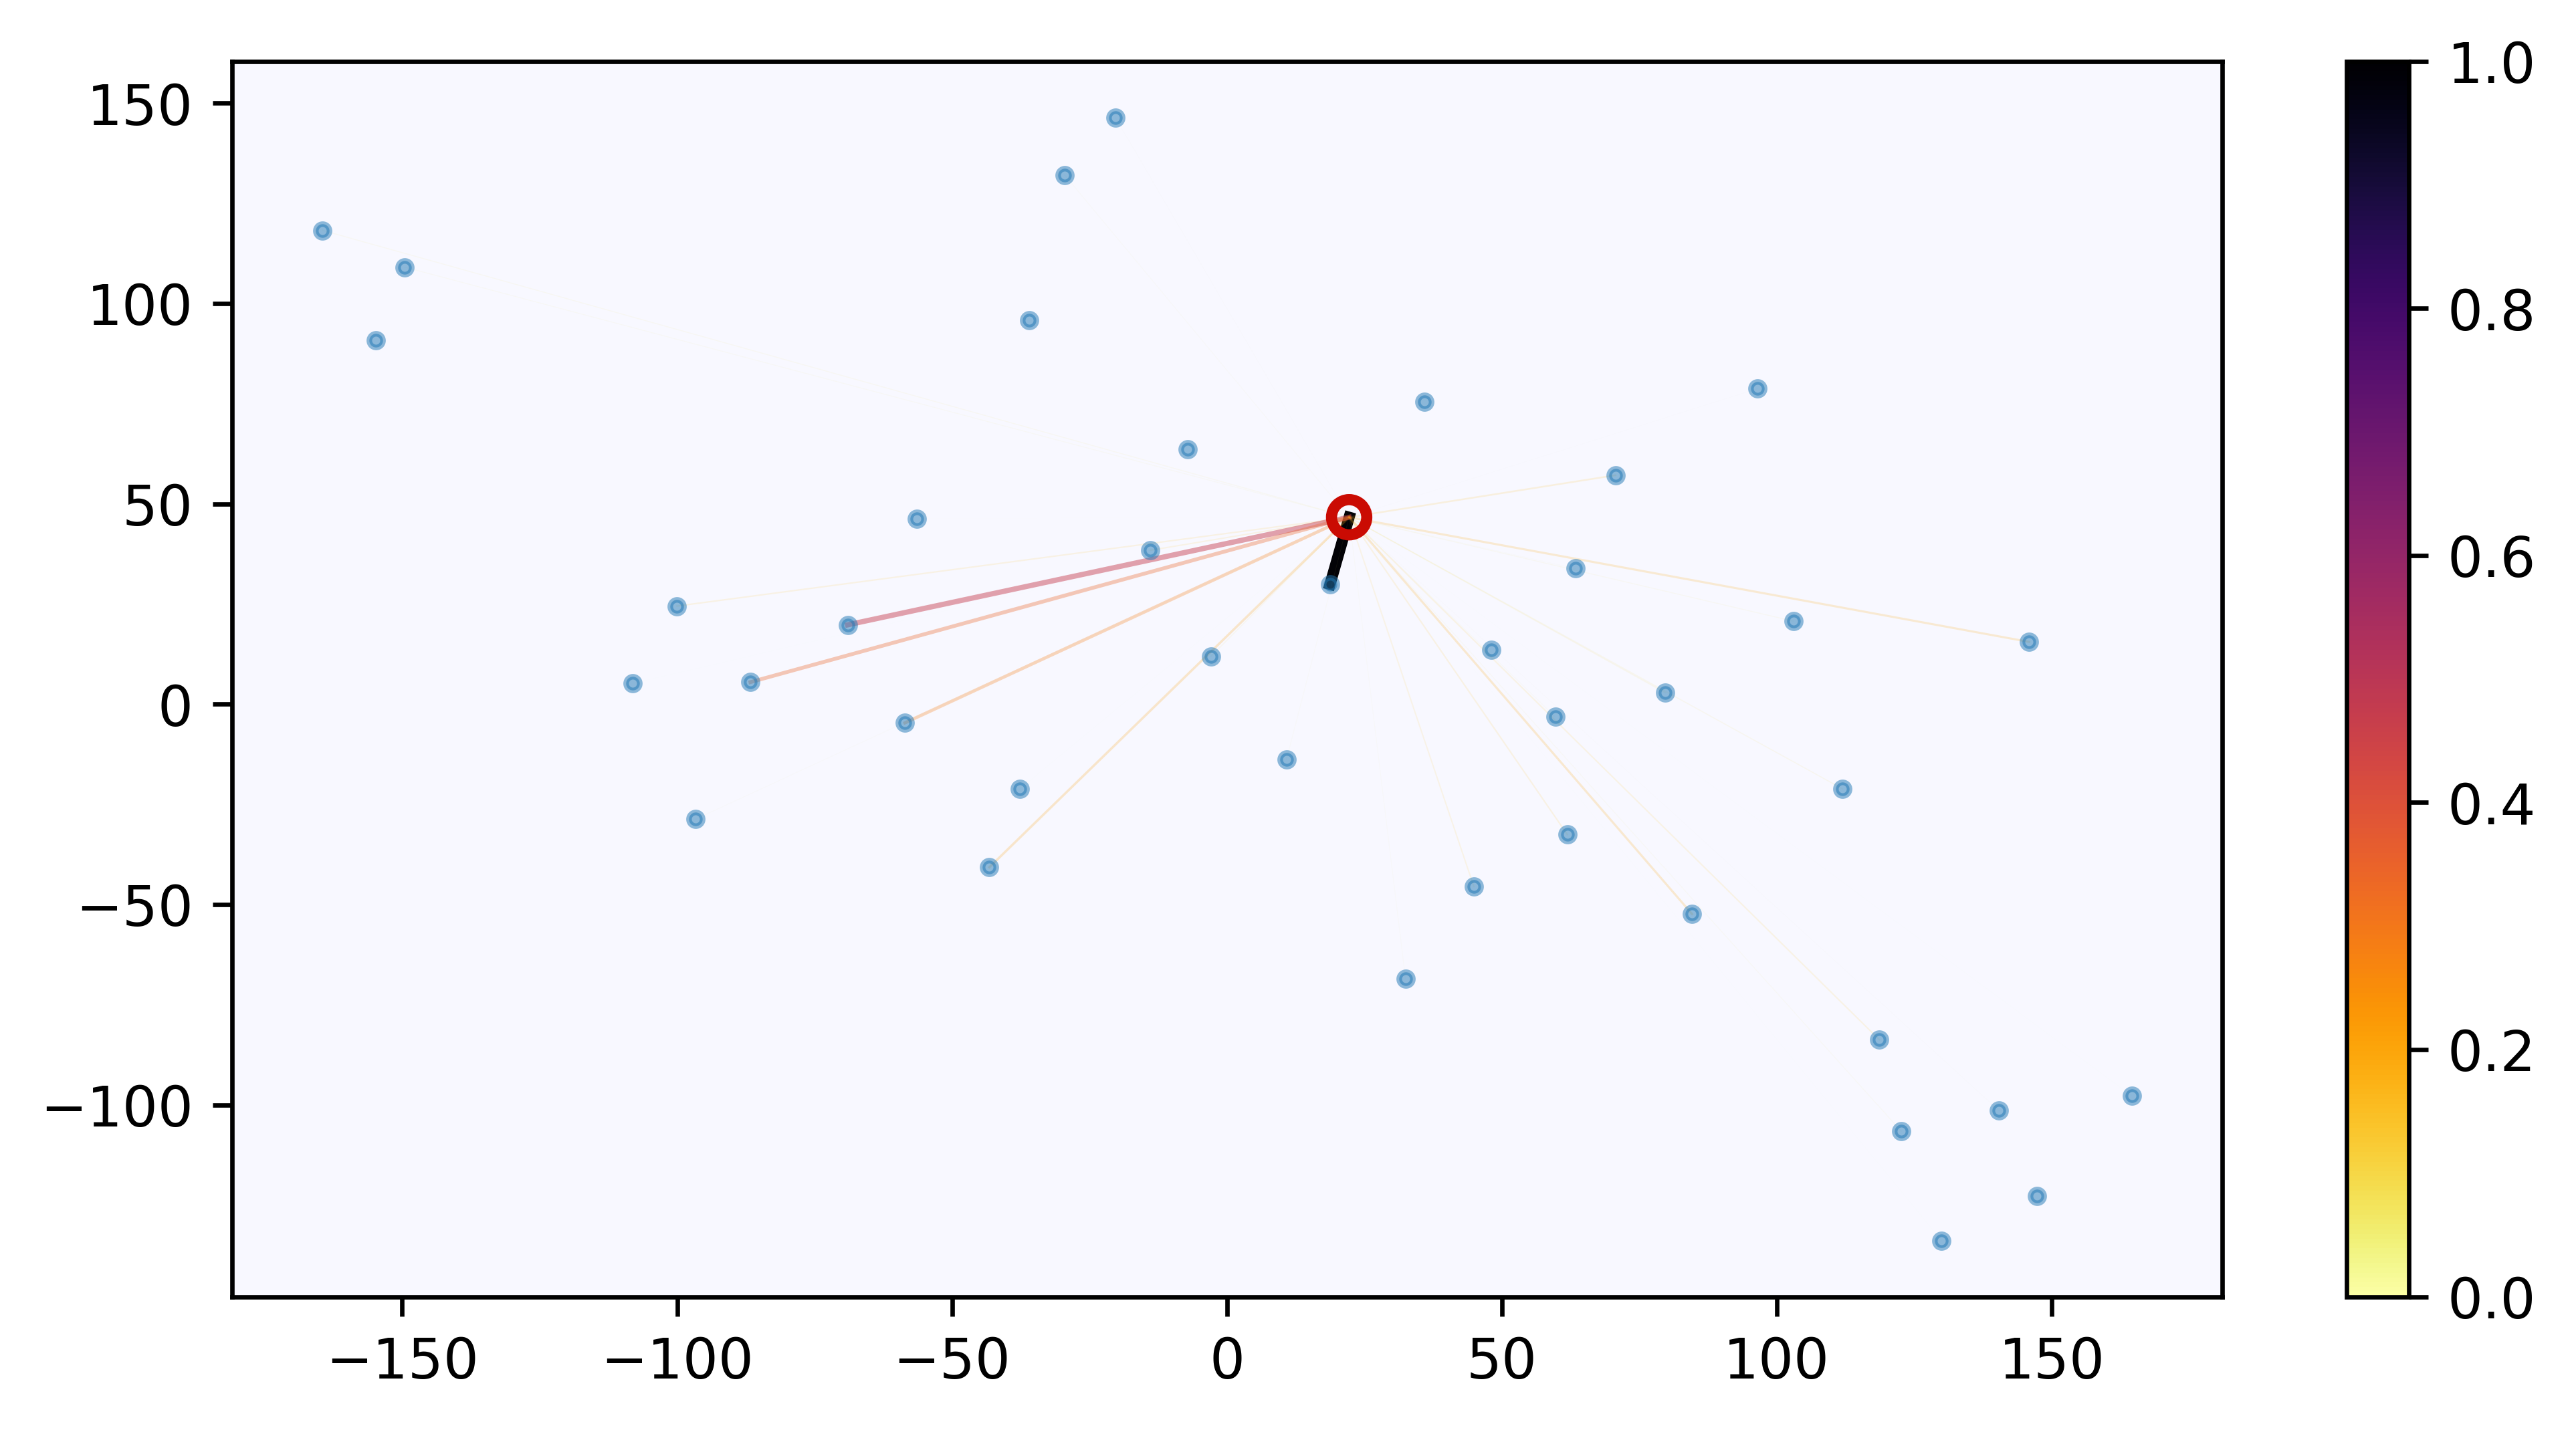

<IPython.core.display.Javascript object>

In [115]:
fig, ax = plt.subplots(figsize=[8, 4])
fig, ax = plot_translation(
    embs=phy_tsne_raf,
    prediction=target,
    fig=fig,
    ax=ax,
    lw=2,
    alpha=1,
    target_size=15,
    pred_size=40,
    size=6,
    color="tab:blue",
    p_alpha=0.5,
)
ax.set_facecolor("ghostwhite")

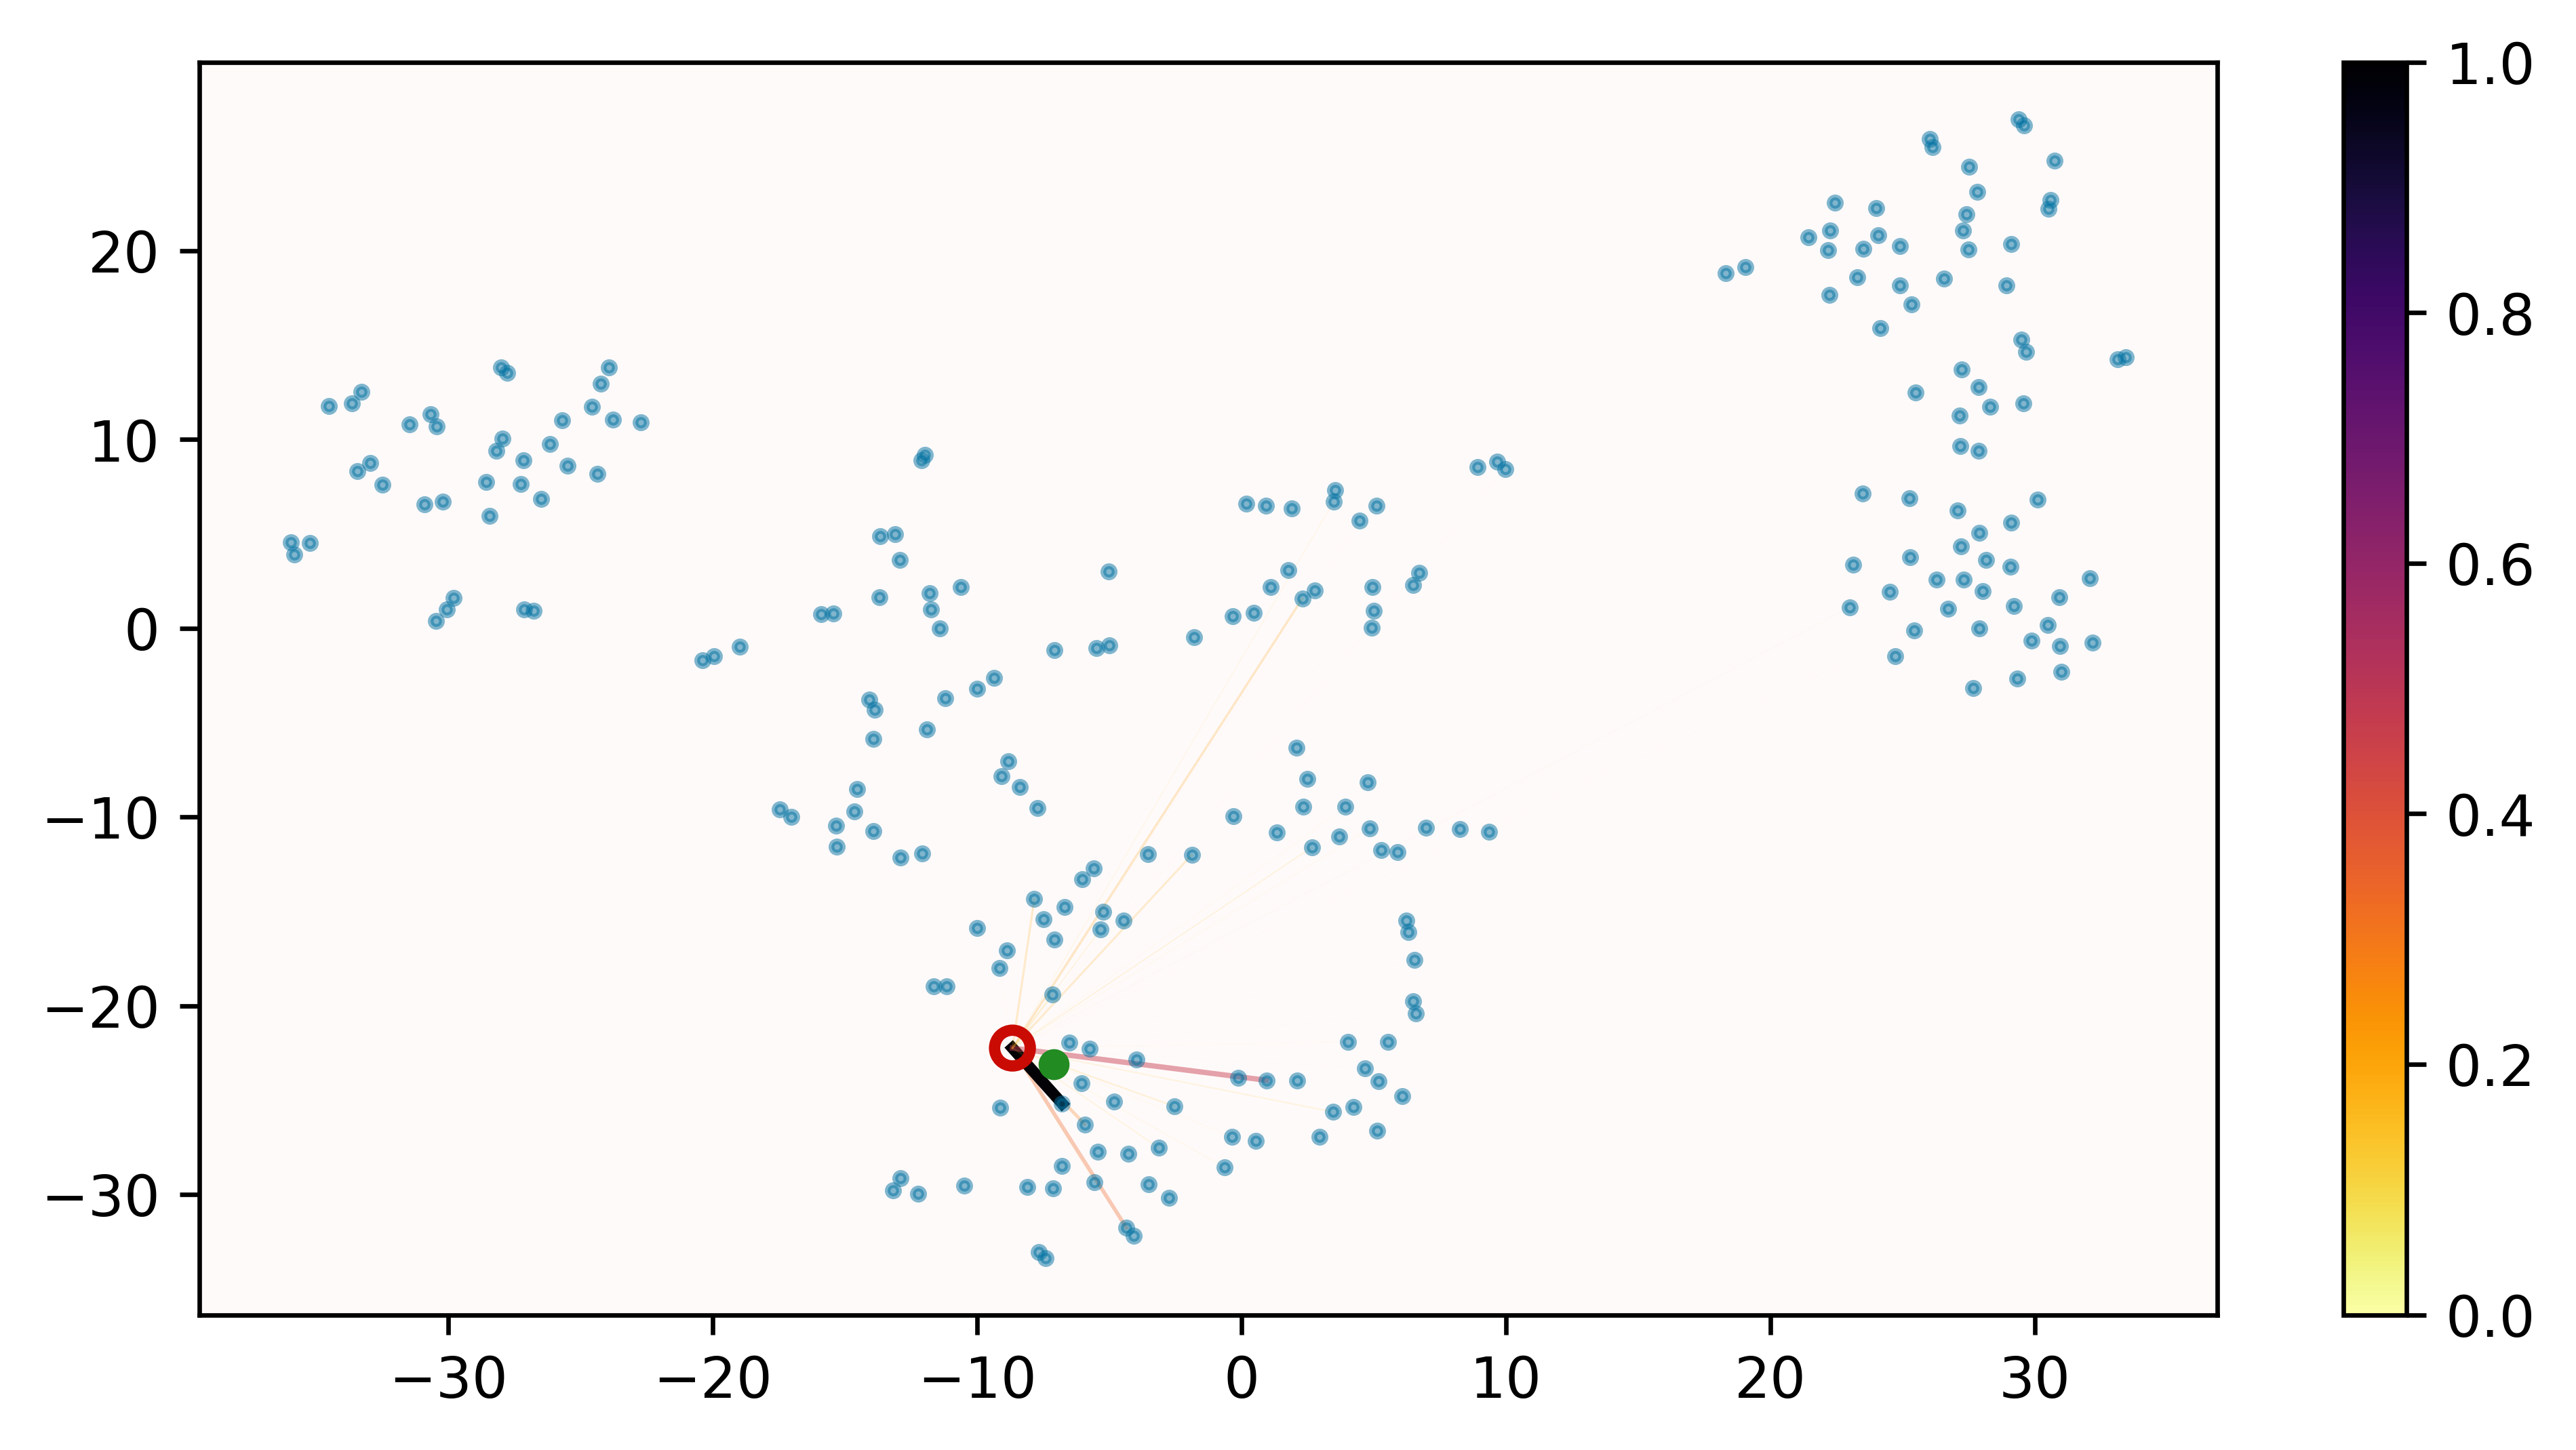

<IPython.core.display.Javascript object>

In [114]:
fig, ax = plt.subplots(figsize=[8, 4])
fig, ax = plot_translation(
    embs=reg_tsne_raf,
    target=target,
    fig=fig,
    ax=ax,
    prediction="PREDICTION",
    pred_size=40,
    pred_color="r",
    target_color="forestgreen",
    lw=2,
    alpha=1,
    target_size=20,
    size=4,
    p_alpha=0.5,
)
ax.set_facecolor("snow")

In [ ]:
tmp = phy_pca_raf.copy()
tmp.loc[:, "abs_weight"] = np.abs(tmp.weight)
tmp.sort_values("abs_weight", ascending=False)